# **Greeks calculator**

It is now time to learn how to calculate the Greeks (Delta, Gamma, Vega, Theta, and Rho) in Python using the mibian library.

# Import the libraries

Mibian is an open source Python library for options pricing and computing Options Greeks. It can be used to calculate the call price, the put price, the implied volatility, the greeks of an option using the Black-Scholes Model (BS).

To install mibian in your pc/laptop type following line from a Jupyter notebook or Python shell:

!pip install mibian

In [ ]:
# Import library
import mibian
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

# Define parameters for the call option contract

stock_price: This is the price at which the stock is trading.

strike_price: This is the price at which the option will be exercised.

interest_rate: This is the risk-free rate prevailing in the economy. In our example, we will take future price as the stock_price and consider the interest rate as 0. This is because the future price includes the interest rate.

days_to_expiry: This the number of calendar days left to expiry.

Volatility: This is the option's implied volatility.

In [2]:
strike_price = 100
interest_rate = 0
days_to_expiry = 29
volatility = 30.0

stock_prices = np.linspace(0.01, 200, 100)

In [11]:
stock_prices

array([1.00000000e-02, 2.03010101e+00, 4.05020202e+00, 6.07030303e+00,
       8.09040404e+00, 1.01105051e+01, 1.21306061e+01, 1.41507071e+01,
       1.61708081e+01, 1.81909091e+01, 2.02110101e+01, 2.22311111e+01,
       2.42512121e+01, 2.62713131e+01, 2.82914141e+01, 3.03115152e+01,
       3.23316162e+01, 3.43517172e+01, 3.63718182e+01, 3.83919192e+01,
       4.04120202e+01, 4.24321212e+01, 4.44522222e+01, 4.64723232e+01,
       4.84924242e+01, 5.05125253e+01, 5.25326263e+01, 5.45527273e+01,
       5.65728283e+01, 5.85929293e+01, 6.06130303e+01, 6.26331313e+01,
       6.46532323e+01, 6.66733333e+01, 6.86934343e+01, 7.07135354e+01,
       7.27336364e+01, 7.47537374e+01, 7.67738384e+01, 7.87939394e+01,
       8.08140404e+01, 8.28341414e+01, 8.48542424e+01, 8.68743434e+01,
       8.88944444e+01, 9.09145455e+01, 9.29346465e+01, 9.49547475e+01,
       9.69748485e+01, 9.89949495e+01, 1.01015051e+02, 1.03035152e+02,
       1.05055253e+02, 1.07075354e+02, 1.09095455e+02, 1.11115556e+02,
      

# Compute Greeks

BS (Black-Scholes) is used for pricing European options on the stocks without dividends. The syntax is as follows:

BS([stock_price, strike_price, interest_rate, days_to_expiry], volatility=x, callPrice=y, putPrice=z).

The BS function returns  the following callPrice, putPrice, callDelta, putDelta, callTheta, putTheta, callRho, putRho, vega, and gamma	


In [30]:
greeks = []
deltas_call = []
deltas_put = []
gammas = []
vegas = []
thetas_call = []
call_prices = []
put_prices = []

for stock_price in stock_prices:
    greeks = mibian.BS([stock_price, strike_price, interest_rate, days_to_expiry], volatility=volatility)
    deltas_call.append(greeks.callDelta)
    deltas_put.append(greeks.putDelta)

    gammas.append(greeks.gamma)
    vegas.append(greeks.vega)
    call_prices.append(greeks.callPrice)
    put_prices.append(greeks.putPrice)

# Greeks for Call Option

Text(0.5, 0.98, 'Delta for Call and Put Option as a function of Stock Price')

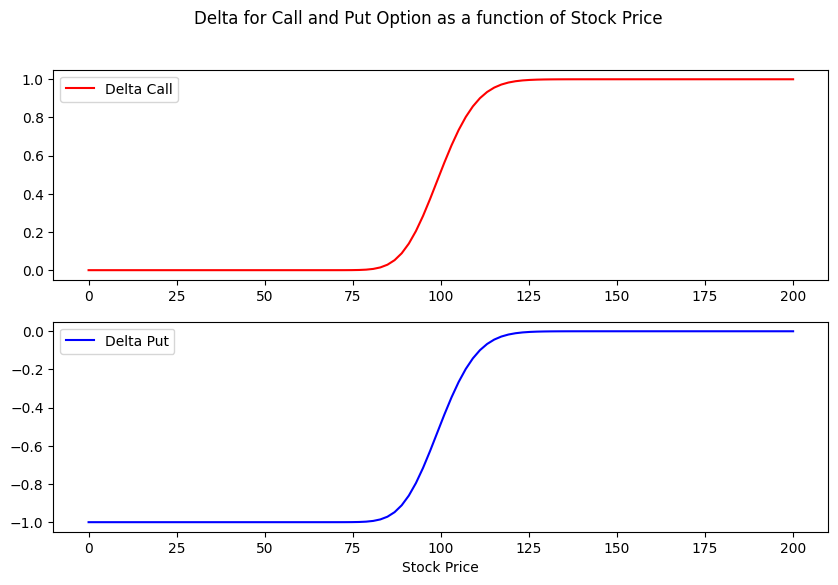

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.plot(stock_prices, deltas_call, c="r", label='Delta Call')
ax2.plot(stock_prices, deltas_put, c="b", label="Delta Put")
ax1.legend()
ax2.legend()
plt.xlabel("Stock Price")
fig.suptitle("Delta for Call and Put Option as a function of Stock Price")

# Call and Put Options prices

Text(0.5, 0.98, 'Delta for Call and Put Option as a function of Stock Price')

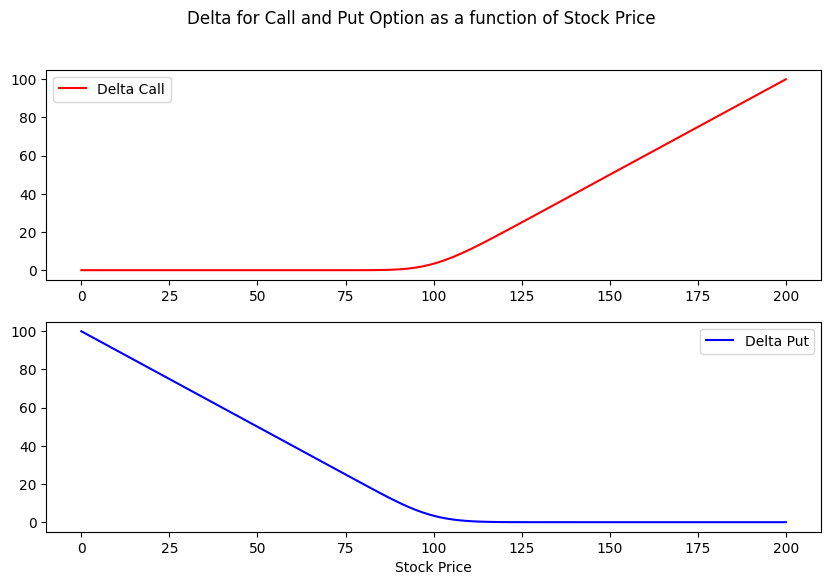

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.plot(stock_prices, call_prices, c="r", label='Delta Call')
ax2.plot(stock_prices, put_prices, c="b", label="Delta Put")
ax1.legend()
ax2.legend()
plt.xlabel("Stock Price")
fig.suptitle("Delta for Call and Put Option as a function of Stock Price")